In [7]:
import os 
os.chdir('C:\\Users\\Administrator\\Desktop\\')


import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from  IPython.display import display

In [8]:
#读取数据，了解数据概况
def set_summary(df):
    print ('{:*^60}'.format('数据前五行'))
    print (df.head())  
    print ('{:*^60}'.format('数据类型'))
    print (df.dtypes)  
    print ('{:*^60}'.format('数据基本描述信息'))
    display(df.describe().astype(str))
    
# 缺失值审查
def na_summary(df):
    na_cols = df.isnull().any(axis=0)
    print('NA Cols:{}'.format(na_cols))
    print('\n')
    na_lines = df.isnull().any(axis=1)
    print ('Total number of NA lines is: {0}'.format(na_lines.sum()))

In [9]:
#数据应用
data = pd.read_csv('tianchi_mobile_recommend_train_user.csv')

set_summary(data)
na_summary(data)

***************************数据前五行****************************
    user_id    item_id  behavior_type user_geohash  item_category  \
0  98047837  232431562              1          NaN           4245   
1  97726136  383583590              1          NaN           5894   
2  98607707   64749712              1          NaN           2883   
3  98662432  320593836              1      96nn52n           6562   
4  98145908  290208520              1          NaN          13926   

            time  
0  2014-12-06 02  
1  2014-12-09 20  
2  2014-12-18 11  
3  2014-12-06 10  
4  2014-12-16 21  
****************************数据类型****************************
user_id           int64
item_id           int64
behavior_type     int64
user_geohash     object
item_category     int64
time             object
dtype: object
**************************数据基本描述信息**************************


,user_id,item_id,behavior_type,item_category
count,12256906.0,12256906.0,12256906.0,12256906.0
mean,71707324.0521,202308365.377,1.10527118345,6846.16223507
std,41229195.0904,116739662.863,0.457266225655,3809.92203077
min,4913.0,64.0,1.0,2.0
25%,35849648.0,101413047.0,1.0,3721.0
50%,72928045.0,202135938.0,1.0,6209.0
75%,107377446.0,303540514.0,1.0,10290.0
max,142455899.0,404562461.0,4.0,14080.0


NA Cols:user_id          False
item_id          False
behavior_type    False
user_geohash      True
item_category    False
time             False
dtype: bool


Total number of NA lines is: 8334824


In [4]:
len((data['user_id'].unique()))

10000

In [10]:
#处理数据
data.drop(['user_geohash'],axis=1,inplace=True)
data['datetime']=pd.to_datetime(data['time'])
na_summary(data)

display(data['datetime'].max())
display(data['datetime'].min())

data['date']=data['time'].str[:11]

NA Cols:user_id          False
item_id          False
behavior_type    False
item_category    False
time             False
datetime         False
dtype: bool


Total number of NA lines is: 0


Timestamp('2014-12-18 23:00:00')

Timestamp('2014-11-18 00:00:00')

In [11]:
#得到分析数据数据
df=data

In [12]:
#PV,日收藏量、日加购购物车量、日支付量
dj=df[df['behavior_type']==1].groupby('date')['behavior_type'].agg(['count'])
sc=df[df['behavior_type']==2].groupby('date')['behavior_type'].agg(['count'])
jg=df[df['behavior_type']==3].groupby('date')['behavior_type'].agg(['count'])
zf=df[df['behavior_type']==4].groupby('date')['behavior_type'].agg(['count'])


#买单人数
tep2=df[df['behavior_type']==4].drop_duplicates(['user_id','date'],keep='first')
mdrs=tep2.groupby('date')['user_id'].agg(['count'])


#UV
tep=df.drop_duplicates(['user_id','date'],keep='first')
uv=tep.groupby('date')['user_id'].agg(['count'])

#货品日变化
item=df.groupby(['date'])['item_id'].agg(['count'])
item_category=df.groupby(['date'])['item_category'].agg(['count'])

temp1=df.drop_duplicates(['item_id','date'],keep='first')
item=temp1.groupby('date')['item_id'].agg(['count'])
temp2=df.drop_duplicates(['item_category','date'],keep='first')
item_category=temp2.groupby('date')['item_category'].agg(['count'])

In [19]:
#合并指标数据
dj.rename(columns={"count":"pv"},inplace=True)
sc.rename(columns={"count":"收藏量"},inplace=True)
jg.rename(columns={"count":"加购物车量"},inplace=True)
zf.rename(columns={"count":"支付次数"},inplace=True)
uv.rename(columns={"count":"uv"},inplace=True)
mdrs.rename(columns={"count":"买单人数"},inplace=True)
item.rename(columns={"count":"商品种类数"},inplace=True)
item_category.rename(columns={"count":"品类数"},inplace=True)

result=pd.concat([dj,sc,jg,zf,uv,mdrs,item,item_category],axis=1)
result.to_csv('result.csv')

In [14]:
#增长点探究
keypoint=df[(df['datetime']>='2014-12-10 00:00:00')&(df['datetime']<='2014-12-13 00:00:00')]

#增长点货品种类数
keypoint_item=keypoint.drop_duplicates(['item_id'],keep="first")
keypoint_item_category=keypoint.drop_duplicates(['item_category'],keep="first")

#增长前货品种类数
beforepoint=df[(df['datetime']<='2014-12-10 00:00:00')]
beforepoint_item=beforepoint.drop_duplicates(['item_id'],keep="first")
beforepoint_item_category=beforepoint.drop_duplicates(['item_category'],keep="first")

#增长后货品种类数
afterpoint=df[(df['datetime']>='2014-12-13 00:00:00')]
afterpoint_item=afterpoint.drop_duplicates(['item_id'],keep="first")
afterpoint_item_category=afterpoint.drop_duplicates(['item_category'],keep="first")


#与增长前货品种类数比较
compare1_item=pd.merge(keypoint_item,beforepoint_item,left_on='item_id',right_on='item_id',how="left")
compare1_item_category=pd.merge(keypoint_item_category,beforepoint_item_category,left_on='item_category',right_on='item_category',how='left')

#与增长后货品种类数比较
compare2_item=pd.merge(keypoint_item,afterpoint_item,left_on='item_id',right_on='item_id',how="left")
compare2_item_category=pd.merge(keypoint_item_category,afterpoint_item_category,left_on='item_category',right_on='item_category',how='left')



#与增长前后的对比
print ('{:*^60}'.format('关键增长点的商品种类数：'))
display(len(keypoint_item))
display(len(keypoint_item_category))

print ('{:*^60}'.format('关键增长点前的商品种类数：'))
display(len(beforepoint_item))
display(len(beforepoint_item_category))

print ('{:*^60}'.format('关键增长点后的商品种类数：'))
display(len(afterpoint_item))
display(len(afterpoint_item_category))


print ('{:*^60}'.format('关键增长的有商品种类而增前没有：'))
display(compare1_item.isnull().sum())
display(compare1_item_category.isnull().sum())



print ('{:*^60}'.format('关键增长的有商品种类而之后没有：'))
display(compare2_item.isnull().sum())
display(compare2_item_category.isnull().sum())

************************关键增长点的商品种类数：************************


502854

6232

***********************关键增长点前的商品种类数：************************


2112492

8502

***********************关键增长点后的商品种类数：************************


739914

6957

**********************关键增长的有商品种类而增前没有：**********************


user_id_x               0
item_id                 0
behavior_type_x         0
item_category_x         0
time_x                  0
datetime_x              0
date_x                  0
user_id_y          298033
behavior_type_y    298033
item_category_y    298033
time_y             298033
datetime_y         298033
date_y             298033
dtype: int64

user_id_x            0
item_id_x            0
behavior_type_x      0
item_category        0
time_x               0
datetime_x           0
date_x               0
user_id_y          168
item_id_y          168
behavior_type_y    168
time_y             168
datetime_y         168
date_y             168
dtype: int64

**********************关键增长的有商品种类而之后没有：**********************


user_id_x               0
item_id                 0
behavior_type_x         0
item_category_x         0
time_x                  0
datetime_x              0
date_x                  0
user_id_y          377625
behavior_type_y    377625
item_category_y    377625
time_y             377625
datetime_y         377625
date_y             377625
dtype: int64

user_id_x            0
item_id_x            0
behavior_type_x      0
item_category        0
time_x               0
datetime_x           0
date_x               0
user_id_y          592
item_id_y          592
behavior_type_y    592
time_y             592
datetime_y         592
date_y             592
dtype: int64

In [24]:
#双十二数据
double12=df[(df['datetime']>='2014-12-12 00:00:00')&(df['datetime']<='2014-12-13 00:00:00')]
#双十二支付量
double12_zf=double12[double12['behavior_type']==4]

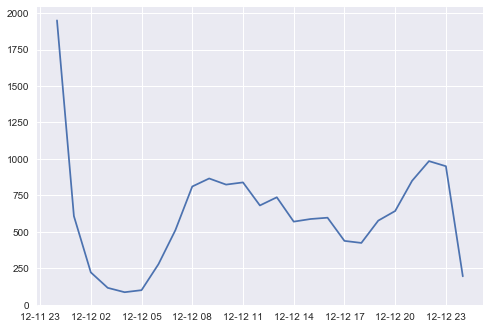

In [22]:
#双十二支付量走势
plt.plot(double12[double12['behavior_type']==4].groupby('datetime')['user_id'].count())
plt.show()

In [23]:
#双十二支付趋势数据导出
qushi12_zf=double12[double12['behavior_type']==4].groupby('datetime')['user_id'].count()
qushi12_zf.to_csv('qushi12_zf.csv')

In [25]:
#双十二当天支付的货品种类数
item_id_double12=double12_zf.drop_duplicates(['item_id'],keep='first')
item_category_double12=double12_zf.drop_duplicates(['item_category'],keep='first')

print("双十二当天付款的商品种类数:%d"%(len(item_id_double12)))
#display(len(item_category_double12))

unique_item=compare1_item[compare1_item['user_id_y'].isnull()]
unique_item_category=compare1_item_category[compare1_item_category['user_id_y'].isnull()]


#关键点对销量的贡献
unique_item_gx=pd.merge(double12_zf,unique_item,left_on='item_id',right_on='item_id',how='left')
unique_item_category_gx=pd.merge(double12_zf,unique_item_category,left_on='item_category',right_on='item_category',how='left')

print("双十二当天付款独有商品种类数：%d"%(len(unique_item_gx[unique_item_gx['user_id_x'].notnull()])))

unique_item_gx_rate=len(unique_item_gx[unique_item_gx['user_id_x'].notnull()])/len(item_id_double12)
unique_item_category_gx_rate=len(unique_item_category_gx[unique_item_category_gx['user_id_x'].notnull()])/len(unique_item_category_gx)

print("独有商品贡献比例: %.2f"%(unique_item_gx_rate))
#print(unique_item_category_gx_rate)

双十二当天付款的商品种类数:13297
双十二当天付款独有商品种类数：5676
独有商品贡献比例: 0.43


In [25]:
unique_item

,user_id_x,item_id,behavior_type_x,item_category_x,time_x,datetime_x,date_x,user_id_y,behavior_type_y,item_category_y,time_y,datetime_y,date_y
0,96610296,161166643,1,3064,2014-12-11 23,2014-12-11 23:00:00,2014-12-11,NaN,NaN,NaN,NaN,NaT,NaN
2,104811265,322736792,1,6513,2014-12-11 19,2014-12-11 19:00:00,2014-12-11,NaN,NaN,NaN,NaN,NaT,NaN
5,103891828,145981615,1,7876,2014-12-11 08,2014-12-11 08:00:00,2014-12-11,NaN,NaN,NaN,NaN,NaT,NaN
6,100684618,94486594,1,10984,2014-12-12 23,2014-12-12 23:00:00,2014-12-12,NaN,NaN,NaN,NaN,NaT,NaN
8,103802946,190848347,1,5232,2014-12-12 22,2014-12-12 22:00:00,2014-12-12,NaN,NaN,NaN,NaN,NaT,NaN
10,104811265,354843735,1,10585,2014-12-12 21,2014-12-12 21:00:00,2014-12-12,NaN,NaN,NaN,NaN,NaT,NaN
14,100509623,395878707,1,3368,2014-12-12 14,2014-12-12 14:00:00,2014-12-12,NaN,NaN,NaN,NaN,NaT,NaN
15,100509623,100583549,1,3368,2014-12-12 14,2014-12-12 14:00:00,2014-12-12,NaN,NaN,NaN,NaN,NaT,NaN
18,104811265,146861310,1,10585,2014-12-12 21,2014-12-12 21:00:00,2014-12-12,NaN,NaN,NaN,NaN,NaT,NaN
24,103891828,89645778,1,4370,2014-12-12 16,2014-12-12 16:00:00,2014-12-12,NaN,NaN,NaN,NaN,NaT,NaN


In [26]:
unique_item_gx

,user_id,item_id,behavior_type,item_category,time,datetime,date,user_id_x,behavior_type_x,item_category_x,time_x,datetime_x,date_x,user_id_y,behavior_type_y,item_category_y,time_y,datetime_y,date_y
0,103802946,303115446,4,5232,2014-12-12 23,2014-12-12 23:00:00,2014-12-12,103802946.0,4.0,5232.0,2014-12-12 23,2014-12-12 23:00:00,2014-12-12,NaN,NaN,NaN,NaN,NaT,NaN
1,100684618,18908000,4,8771,2014-12-12 23,2014-12-12 23:00:00,2014-12-12,100684618.0,4.0,8771.0,2014-12-12 23,2014-12-12 23:00:00,2014-12-12,NaN,NaN,NaN,NaN,NaT,NaN
2,116730636,222968346,4,10703,2014-12-12 09,2014-12-12 09:00:00,2014-12-12,116730636.0,4.0,10703.0,2014-12-12 09,2014-12-12 09:00:00,2014-12-12,NaN,NaN,NaN,NaN,NaT,NaN
3,100509623,270008666,4,11241,2014-12-12 01,2014-12-12 01:00:00,2014-12-12,100509623.0,4.0,11241.0,2014-12-12 01,2014-12-12 01:00:00,2014-12-12,NaN,NaN,NaN,NaN,NaT,NaN
4,100509623,308435187,4,3064,2014-12-12 00,2014-12-12 00:00:00,2014-12-12,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaT,NaN
5,103891828,98292282,4,12067,2014-12-12 10,2014-12-12 10:00:00,2014-12-12,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaT,NaN
6,100509623,270008666,4,11241,2014-12-12 01,2014-12-12 01:00:00,2014-12-12,100509623.0,4.0,11241.0,2014-12-12 01,2014-12-12 01:00:00,2014-12-12,NaN,NaN,NaN,NaN,NaT,NaN
7,103891828,367066075,4,6513,2014-12-12 17,2014-12-12 17:00:00,2014-12-12,103891828.0,4.0,6513.0,2014-12-12 17,2014-12-12 17:00:00,2014-12-12,NaN,NaN,NaN,NaN,NaT,NaN
8,104221274,102529103,4,13230,2014-12-12 23,2014-12-12 23:00:00,2014-12-12,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaT,NaN
9,107874169,320529646,4,3271,2014-12-12 12,2014-12-12 12:00:00,2014-12-12,107874169.0,4.0,3271.0,2014-12-12 12,2014-12-12 12:00:00,2014-12-12,NaN,NaN,NaN,NaN,NaT,NaN
